# Scan of L3 AIRS Data on H2O during One Year
------------------------------------------------------------------

- author: Sylvie Dagoret-Campagne
- creation November 22 Novembre 2016


### purpose:

Analyse AIRS instrument data from AQUA satellite for LSST air transparency simulation

- http://acdisc.gsfc.nasa.gov/data/Aqua_AIRS_Level3/AIRX3STM.006/

These data are provided by the Goddard Earth Science:

- http://disc.gsfc.nasa.gov/acdisc


## 1) python libraries
---------------------------

In [126]:
# Set up matplotlib and use a nicer set of plot parameters
%config InlineBackend.rc = {}
import matplotlib
import matplotlib as mpl
matplotlib.rc_file("templates/matplotlibrc")
import matplotlib.pyplot as plt
%matplotlib inline

In [127]:
import datetime

In [128]:
from matplotlib.dates import MonthLocator, WeekdayLocator,DateFormatter
from matplotlib.dates import MONDAY

In [129]:
mondays = WeekdayLocator(MONDAY)
months = MonthLocator(range(1, 13), bymonthday=1, interval=1)
monthsFmt = DateFormatter("%b '%y")

In [130]:
import os
import re
import numpy as np
from mpl_toolkits.basemap import Basemap
from matplotlib import colors
from matplotlib.backends.backend_pdf import PdfPages
import pandas as pd

In [131]:
from astropy import units as u
from astropy.coordinates import SkyCoord

In [132]:
import pyhdf

In [133]:
from pyhdf.SD import SD,SDC

In [134]:
import libAIRSL3Data as airs  # My own library

In [135]:
############################################################################
def ensure_dir(f):
    d = os.path.dirname(f)
    if not os.path.exists(f):
        os.makedirs(f)
#########################################################################

## 1)  Configuration
-------------------------

In [136]:
# where are the HDF files
# 9 month
#HDFEOS_ZOO_DIR="/Users/dagoret-campagnesylvie/MacOsX/LSST/MyWork/GitHub/NASA_AIRS_AQUA_DATA/AIRH3STM/2016/h4" 
# 10 months
HDFEOS_ZOO_DIR="/Users/dagoret-campagnesylvie/MacOsX/LSST/MyWork/GitHub/NASA_AIRS_AQUA_DATA/AIRS3STM/2016/h4"

In [137]:
path=HDFEOS_ZOO_DIR

In [138]:
# The selected data field
DATAFIELD_NAME =  'TotH2OVap_D'   # Select Ozone column Depth

In [139]:
DATAFIELD_UNIT = DATAFIELD_NAME+'(kg/m2)'  # Unit

In [140]:
DATA_TITLE = 'Water Vapor column depth measured by AIRS in 2016 at CTIO/LSST'  # Title in figures

In [141]:
pandas_filename='AIRS_2016_'+DATAFIELD_NAME+'.csv'
pandas_fieldname=['dates','average','ct','err','std','min','max']

In [142]:
figfilename1='AIRS2016_'+DATAFIELD_NAME+'.jpg'
figfilename2='AIRS2016_'+DATAFIELD_NAME+'pres'+'.jpg'

In [143]:
# Select observatory
loc=airs.observatory_location('ctio')

### 1.2) Getting the list of the files
------------------------------

In [144]:
h4_files = [f for f in os.listdir(path) if f.endswith('.hdf')]  
NBFILES=len(h4_files)

full_h4files=[]

for file in h4_files:
    fname = os.path.join(path, file)
    full_h4files.append(fname) 

####  Fill information on years and months from the filenames

In [145]:
years_coll = []
months_coll = []
for file in h4_files:
    the_date=re.findall('^AIRS[.](.+)[.]L3.*',file)[0]
    the_year_str=the_date.split('.')[0]
    the_month_str=the_date.split('.')[1]
    years_coll.append(int(the_year_str))
    months_coll.append(int(the_month_str))
    

#### Build the list of dates

In [146]:
dates_data= [datetime.date(years_coll[idx], months_coll[idx], 1) for idx in range(0,NBFILES) ]

In [147]:
data_monthaverage=[]
data_month_ct=[]
data_month_err=[]
data_month_max=[]
data_month_min=[]
data_month_sdev=[]

for idf in np.arange(0,NBFILES):
    FILE_NAME=full_h4files[idf]
    data3D=airs.GetData(FILE_NAME,DATAFIELD_NAME)    
    data_aver= data3D[:,:] ## Ozone has no additional dimensions      
    lat = airs.GetData(FILE_NAME,'Latitude')
    latitude = lat[:,:]
    lon = airs.GetData(FILE_NAME,'Longitude')
    longitude = lon[:,:]
    
    # Handle fill value.
    attrs = data3D.attributes(full=1)
    fillvalue=attrs["_FillValue"]

    # fillvalue[0] is the attribute value.
    fv = fillvalue[0]
    data_aver[data_aver == fv] = np.nan
    data_aver = np.ma.masked_array(data_aver, np.isnan(data_aver))
    (ctio_min_long_index, ctio_min_lat_index,extrdata)=airs.SelectBin(longitude,latitude,data_aver,loc[0],loc[1])
    data_monthaverage.append(extrdata)
    
    
    # Get the Ct
    DATAFIELD_NAME_CT=DATAFIELD_NAME+'_ct'
    data3D=airs.GetData(FILE_NAME,DATAFIELD_NAME_CT)
    data_ct= data3D[:,:] ## Ozone has no additional dimensions
    #attrs = data3D.attributes(full=1)
    #fillvalue=attrs["_FillValue"]
    # fillvalue[0] is the attribute value.
    #fv = fillvalue[0]
    #data_ct[data_ct == fv] = np.nan
    #data_ct = np.ma.masked_array(data_ct, np.isnan(data_ct))
    (ctio_min_long_index, ctio_min_lat_index,extrdata)=airs.SelectBin(longitude,latitude,data_ct,loc[0],loc[1])
    data_month_ct.append(extrdata)
    
    
    
    # Get the errors
    DATAFIELD_NAME_ERR=DATAFIELD_NAME+'_err'
    data3D=airs.GetData(FILE_NAME,DATAFIELD_NAME_ERR)
    data_err= data3D[:,:] ## Ozone has no additional dimensions
    
    (ctio_min_long_index, ctio_min_lat_index,extrdata)=airs.SelectBin(longitude,latitude,data_err,loc[0],loc[1])
    data_month_err.append(extrdata)
    
    
    # Get the STD
    DATAFIELD_NAME_STD=DATAFIELD_NAME+'_sdev'
    data3D=airs.GetData(FILE_NAME,DATAFIELD_NAME_STD)
    data_std= data3D[:,:] ## Ozone has no additional dimensions
    
    (ctio_min_long_index, ctio_min_lat_index,extrdata)=airs.SelectBin(longitude,latitude,data_std,loc[0],loc[1])
    data_month_sdev.append(extrdata)
    
    # Get the MAX
    DATAFIELD_NAME_MAX=DATAFIELD_NAME+'_max'
    data3D=airs.GetData(FILE_NAME,DATAFIELD_NAME_MAX)
    data_max= data3D[:,:] ## Ozone has no additional dimensions
    
    (ctio_min_long_index, ctio_min_lat_index,extrdata)=airs.SelectBin(longitude,latitude,data_max,loc[0],loc[1])
    data_month_max.append(extrdata)
    
    
        # Get the MIN
    DATAFIELD_NAME_MIN=DATAFIELD_NAME+'_min'
    data3D=airs.GetData(FILE_NAME,DATAFIELD_NAME_MIN)
    data_min= data3D[:,:] ## Ozone has no additional dimensions
    
    (ctio_min_long_index, ctio_min_lat_index,extrdata)=airs.SelectBin(longitude,latitude,data_min,loc[0],loc[1])
    data_month_min.append(extrdata)
    
    

### Transform into numpy array

In [148]:
data_month_aver=np.array(data_monthaverage)
av=data_month_aver.mean()
data_month_std=np.array(data_month_sdev)
data_month_ct=np.array(data_month_ct)
data_month_err=np.array(data_month_err)
data_month_p1std=np.array(data_monthaverage)+np.array(data_month_sdev)
data_month_m1std=np.array(data_monthaverage)-np.array(data_month_sdev)
data_month_min=np.array(data_month_min)
data_month_max=np.array(data_month_max)
dates_data=np.array(dates_data)

## 3) Plots

### Plot varation month to month

In [149]:
YMIN=0
YMAX=30

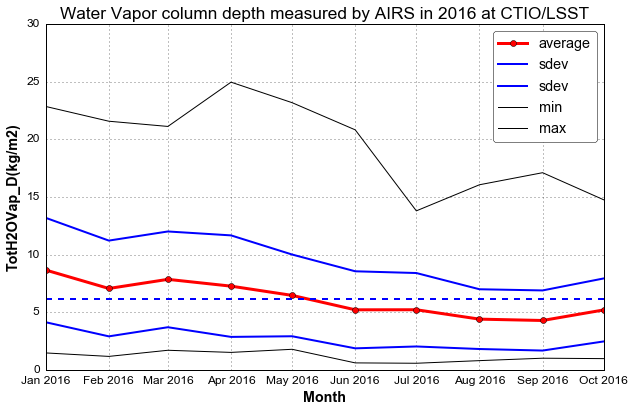

In [150]:
fig=plt.figure(figsize=(10,6))
ax=fig.add_subplot(1,1,1)

ax.plot_date(dates_data, data_month_aver,'ro-',label='average',linewidth=3)
ax.plot_date(dates_data, data_month_p1std,'b-',label='sdev',linewidth=2)
ax.plot_date(dates_data, data_month_m1std,'b-',label='sdev',linewidth=2)
ax.plot_date(dates_data, data_month_min,'k-',label='min',linewidth=1)
ax.plot_date(dates_data, data_month_max,'k-',label='max',linewidth=1)


avline=np.ones(NBFILES)*av
ax.plot_date(dates_data, avline,'b--',linewidth=2)

ax.set_ylim(YMIN,YMAX)


ax.set_ylabel(DATAFIELD_UNIT)
ax.set_xlabel('Month')

ax.grid(True)


plt.title(DATA_TITLE)
plt.legend(loc='best')

plt.savefig(figfilename1, bbox_inches='tight')

### Plot relative error

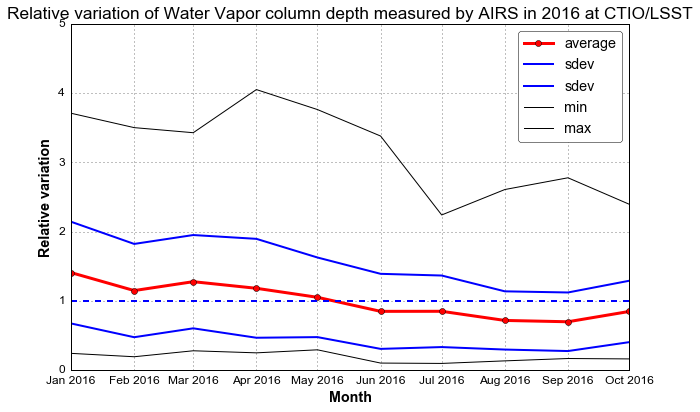

In [151]:

fig=plt.figure(figsize=(10,6))
ax=fig.add_subplot(1,1,1)

ratio_data_month_aver=data_month_aver/av

ratio_data_month_p1std= data_month_p1std/av
ratio_data_month_m1std =data_month_m1std/av

ratio_data_month_min = data_month_min/av
ratio_data_month_max = data_month_max/av

ax.plot_date(dates_data, ratio_data_month_aver,'ro-',label='average',linewidth=3)
ax.plot_date(dates_data, ratio_data_month_p1std,'b-',label='sdev',linewidth=2)
ax.plot_date(dates_data, ratio_data_month_m1std,'b-',label='sdev',linewidth=2)
ax.plot_date(dates_data, ratio_data_month_min,'k-',label='min',linewidth=1)
ax.plot_date(dates_data, ratio_data_month_max,'k-',label='max',linewidth=1)


avline=np.ones(NBFILES)
ax.plot_date(dates_data, avline,'b--',linewidth=2)

ax.set_ylim(0.,5)


ax.set_ylabel('Relative variation')
ax.set_xlabel('Month')

ax.grid(True)

title = 'Relative variation of '+ DATA_TITLE
plt.title(title)
plt.legend(loc='best')
plt.savefig(figfilename2, bbox_inches='tight')

## 4)  Save data  in file pandas
----------------------------------------

In [152]:
data_dict={pandas_fieldname[0]:dates_data,
           pandas_fieldname[1]:data_month_aver, 
           pandas_fieldname[2]:data_month_ct, 
           pandas_fieldname[3]:data_month_err,
           pandas_fieldname[4]:data_month_std, 
           pandas_fieldname[5]:data_month_min,
           pandas_fieldname[6]:data_month_max}

In [153]:
dataset=pd.DataFrame(data_dict,columns={pandas_fieldname[0],
                                        pandas_fieldname[1],
                                        pandas_fieldname[2],
                                        pandas_fieldname[3],
                                        pandas_fieldname[4],
                                        pandas_fieldname[5],
                                        pandas_fieldname[6]})

In [154]:
dataset.describe()

,std,err,min,max,average,ct
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,3.526562,1.130859,1.155371,19.627344,6.158740,614.800000
std,0.750110,0.183305,0.440208,3.885825,1.512790,72.739719
min,2.593750,0.855469,0.567871,13.796875,4.280273,457.000000
25%,2.847656,1.017578,0.839478,16.324219,5.199097,577.000000
50%,3.445312,1.148438,1.084473,20.976562,5.835938,625.000000
75%,4.156250,1.226562,1.499268,22.539062,7.211548,662.750000
max,4.531250,1.445312,1.780273,24.968750,8.660156,697.000000


In [155]:
dataset.head()

,std,dates,err,min,max,average,ct
0,4.531250,2016-01-01,1.445312,1.464844,22.859375,8.660156,697
1,4.156250,2016-02-01,1.164062,1.163086,21.578125,7.059570,656
2,4.156250,2016-03-01,1.226562,1.695312,21.125000,7.851562,696
3,4.406250,2016-04-01,1.226562,1.510742,24.968750,7.262207,565
4,3.546875,2016-05-01,1.312500,1.780273,23.187500,6.458984,620


In [156]:
dataset.to_csv(pandas_filename)

In [157]:
saved_dataset=pd.read_csv(pandas_filename)

In [158]:
saved_dataset.head()

,Unnamed: 0,std,dates,err,min,max,average,ct
0,0,4.531250,2016-01-01,1.445312,1.464844,22.859375,8.660156,697
1,1,4.156250,2016-02-01,1.164062,1.163086,21.578125,7.059570,656
2,2,4.156250,2016-03-01,1.226562,1.695312,21.125000,7.851562,696
3,3,4.406250,2016-04-01,1.226562,1.510742,24.968750,7.262207,565
4,4,3.546875,2016-05-01,1.312500,1.780273,23.187500,6.458984,620
